# Exercise for  MSM estimation with respy and estimagic

This guide contains an estimation exercise for the use of [respy](https://respy.readthedocs.io/en/latest/)'s method of simulated moments interface with [estimagic](https://estimagic.readthedocs.io/en/latest/)'s optimization capabilities.

A detailed guide to the MSM interface itself is linked below. It provides a overview of `respy`'s MSM functions and outlines how inputs maybe specified to construct a criterion function. This guide as a next step showcases a small estimation exercise to estimate parameters with the specified criterion function.

## Motivation

The purpose of this exercise is to check whether the estimation procedure and criterion function are correctly specified for the estimation of a model. This notebook, therefore, is not a guide to estimating a model in general but instead showcases a test of the setup that can precede actual estimation. 

Estimation of structural models is a tedious and complicated task, as we attempt to optimize a usually non-smooth criterion function with respect to a large number of parameters. Optimizers may easily get stuck in local optima for such criterion functions, preventing us from finding a global solution. 

In this exercise, we will work with a simulated model for which we know the true parameter vector and may control all aspects of the data generating process of the "observed" as well as simulated data. We will attempt to estimate a misspecified model to perturb the true parameter vector in a controlled fashion and then try to retrieve the parameters for the correct model specification using the perturbed vector as starting values. 

This exercise thus allows us to test whether the general setup of our optimization problem works and an optimizer is successful in approaching the optimum for a correctly specified model. It also allows us to get a sense of how sensitive the estimation process is to different calibration choices like bounds, algorithms, and the specification of the criterion function.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import copy
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path


import respy as rp
from respy.method_of_simulated_moments import _harmonize_input
from estimagic.logging.create_database import load_database
from estimagic.logging.read_database import read_last_iterations
from estimagic import minimize

## Configure MSM inputs

To configure the MSM criterion function for estimation, we need to specify a model that will be passed on to the simulator, define moment and replacement functions, derive empirical moments, and specify a weighting matrix. We will use ``respy``'s `kw_94_one` example model for the exercise. The following section will outline all the inputs needed to set up the estimation.

Note that this model is completely simulated, which gives us complete control of all aspects of the model as we can determine the data generating process of not only the simulated data, but the observed data as well.

### Model

We can generate the model using `respy`'s `get_example_model` function. We will treat the parameter vector from this specification as the *true* parameter vector that we will try to retrieve during estimation. With it comes our *observed data* that is generated using the true parameters and which we will match simulated moments generated from candidate parameter vectors to during estimation.

In [2]:
model = "kw_94_one"

In [3]:
params, options, data_obs = rp.get_example_model(model)

### Moment & Replacement Functions

Aside from the parameters and options that are used to define the model, we need to define functions to compute moments and to replace missing moments for the simulated data we generate for candidate parameter vectors during estimation.

In [4]:
def calc_choice_frequencies(df):
    """Calculate choice frequencies."""
    return df.groupby("Period").Choice.value_counts(normalize=True).unstack()


def calc_wage_distribution(df):
    """Calculate wage distribution."""
    return df.groupby(["Period"])["Wage"].describe()[["mean", "std"]]


def replace_nans(df):
    """Replace missing values in data."""
    return df.fillna(0)

We save the arguments in dictionaries to later pass on to the criterion function. The function ``replace_nans`` can be left as it is because we only use one replacement function for all moments.

In [5]:
calc_moments = {
    "Choice Frequencies": calc_choice_frequencies,
    "Wage Distribution": calc_wage_distribution,
}

### Empirical Moments

Now that we have defined the functions needed to compute moments, we can use them to compute the empirical or observed moments for our data. We apply the replacement function to the empirical moments as well.

In [6]:
empirical_moments = {
    "Choice Frequencies": replace_nans(calc_choice_frequencies(data_obs)),
    "Wage Distribution": replace_nans(calc_wage_distribution(data_obs)),
}

### Weighting Matrix

Additionally we compute a diagonal variance weighting matrix using a bootstrapping procedure using the function below.

In [7]:
def get_weighting_matrix(data, calc_moments, num_boot, sample_boot):
    """ Compute weighting matrix for estimation with MSM."""
    np.random.seed(123)

    # Turn calc_moments into list in case it is a dictionary or single function.
    calc_moments = _harmonize_input(calc_moments)
    index_base = data.index.get_level_values("Identifier").unique()

    moments_sample = list()
    for _ in range(num_boot):
        ids_boot = np.random.choice(index_base, sample_boot, replace=False)
        moments_boot = [func(data.loc[ids_boot, :]) for func in calc_moments]
        
        moments_boot = rp.get_flat_moments(moments_boot)

        moments_sample.append(moments_boot)

    moments_var = np.array(moments_sample).var(axis=0)
    weighting_matrix = np.diag(moments_var ** (-1))

    return np.nan_to_num(weighting_matrix)

In [8]:
weighting_matrix = get_weighting_matrix(
    data=data_obs,
    calc_moments=calc_moments,
    num_boot=300,
    sample_boot=500,
)

### Criterion Function

Now that we have specified all inputs, we can pass them on to respy's `get_msm_func` to generate the criterion function. So far, this guide has just repeated the steps outlined in the general [method of simulated moments](https://respy.readthedocs.io/en/latest/how_to_guides/msm.html) guide (with the exception of the choice of weighting matrix).

In [9]:
criterion_msm = rp.get_msm_func(
    params=params,
    options=options,
    calc_moments=calc_moments,
    replace_nans=replace_nans,
    empirical_moments=empirical_moments,
    weighting_matrix=weighting_matrix,
)

## Configure optimization

In the next step we address the elements that are needed for optimization of the criterion function. These specifications are undertaken specifically for estimation with estimagic. Other optimization packages might require different configurations. 

### Add bounds to parameters

As a first step we define bounds for our parameter vector that aid the optimizer in estimation. Depending on the model, some parameters may have natural bounds that can be used (i.e. the discount factor ranges between 0 and 1). The choice of bounds is a decisive factor in the success of optimization and may require many adjustments during an actual estimation process when the true parameter values are unknown.

Since this is a simulation exercise, we know the true parameter value and can define our bounds accordingly.

In [10]:
def add_params_bounds(params, deviation):
    """ Add upper and lower bounds in parameter vector for optimization."""
    params = params.copy()
    # Compute relative deviation of parameter values as bounds.
    params["lower"] = params["value"] - abs((params["value"] * deviation))
    params["upper"] = params["value"] + abs((params["value"] * deviation))

    # Parameters with value 0 get the absolute deviation as bounds.
    params["upper"] = params["upper"].replace(0, deviation)
    params["lower"] = params["lower"].replace(0, -deviation)

    # Bounds for specififc parameters, shocks to not get bounds.
    params.loc[("delta", "delta"), ("lower", "upper")] = (0, 1)
    params.loc["shocks_sdcorr", ("lower", "upper")] = (-(np.inf), np.inf)

    return params

Below we select bounds that constitute a 5% deviation from the true values (or an absolute deviation of 0.05 for parameters that are 0 at the true value. Note that the bounds should be named ``lower`` and ``upper`` so ``estimagic`` can recognize them as bounds.

In [11]:
params = add_params_bounds(params, 0.05)

In [12]:
params

value  \
category                name                                   
delta                   delta                         0.9500   
wage_a                  constant                      9.2100   
                        exp_edu                       0.0380   
                        exp_a                         0.0330   
                        exp_a_square                 -0.0005   
                        exp_b                         0.0000   
                        exp_b_square                  0.0000   
wage_b                  constant                      8.4800   
                        exp_edu                       0.0700   
                        exp_b                         0.0670   
                        exp_b_square                 -0.0010   
                        exp_a                         0.0220   
                        exp_a_square                 -0.0005   
nonpec_edu              constant                      0.0000   
                        at_least_twelve_exp_edu       0.0000   
                        not_edu_last_period       -4000.0000   
nonpec_home             constant                  17750.0000   
shocks_sdcorr           sd_a                          0.2000   
                        sd_b                          0.2500   
                        sd_edu                     1500.0000   
                        sd_home                    1500.0000   
                        corr_b_a                      0.0000   
                        corr_edu_a                    0.0000   
                        corr_edu_b                    0.0000   
                        corr_home_a                   0.0000   
                        corr_home_b                   0.0000   
                        corr_home_edu                 0.0000   
lagged_choice_1_edu     probability                   1.0000   
initial_exp_edu_10      probability                   1.0000   
maximum_exp             edu                          20.0000   
inadmissibility_penalty inadmissibility_penalty -400000.0000   

                                                                                           comment  \
category                name                                                                         
delta                   delta                                                      discount factor   
wage_a                  constant                                               log of rental price   
                        exp_edu                          return to an additional year of schooling   
                        exp_a                                     return to same sector experience   
                        exp_a_square                   return to same sector, quadratic experience   
                        exp_b                                    return to other sector experience   
                        exp_b_square                  return to other sector, quadratic experience   
wage_b                  constant                                               log of rental price   
                        exp_edu                          return to an additional year of schooling   
                        exp_b                                     return to same sector experience   
                        exp_b_square                   return to same sector, quadratic experience   
                        exp_a                                    return to other sector experience   
                        exp_a_square                  return to other sector, quadratic experience   
nonpec_edu              constant                            constant reward for choosing education   
                        at_least_twelve_exp_edu        reward for going to college (tuition, etc.)   
                        not_edu_last_period                        reward for going back to school   
nonpec_home             constant                         constant reward of non-market alternative   
shoc

### Create configuration dictionary for optimization

There are additional arguments we need to pass on to the optimizer like the optimization algorithm and  constraints. We can get the constraints for the selected model from `respy` using the function `get_parameter_constraints`. We collect the elements in a dictionary that can be passed on to the optimizer.

In [13]:
optim_config = {
    "algorithm": "nlopt_bobyqa",
    "constraints": rp.get_parameter_constraints(model),
}

### Logging

``estimagic`` creates a database file for each optimization it conducts. The database file contains useful information about the optimization process like the criterion and parameter values at each iteration. In order to save the databases for each optimization and prevent them from being overwritten when a new optimization is launched, we can define a function that creates a logging path based on the current date and time to ensure a unique logging path for each optimization.

In [14]:
def create_logging_path(target_dir):
    """Creates a directory in the target_dir based on current date and time."""
    cwd = Path.cwd()
    time = datetime.now().strftime("%d.%m.%Y_%H-%M-%S")
    target = cwd / target_dir /time
    target.mkdir(parents=True, exist_ok=True)
    return str(target)

In [15]:
logging_path = create_logging_path("logging")

## Estimation Exercise

Finally, we can perform the estimation exercise. The target of this exercise is to test whether an optimizer manages to retrieve the true parameter vector (approximately) after we have induced it to distance itself from the true values. To generate starting values for the estimation that differ from the true vector, we misspecify the model by fixing the discount factor to 0, thus rendering agents myopic in our model. We then attempt estimate the parameters for the misspecified model but will fail to retrieve them as the discount factor is fixed to zero. Within the bounds chosen above, the estimated values for the free parameters will thus diverge from the true ones we started with. 

In the next step, delta is fixed back to the correct value and the resulting parameter vector from the last step is used as the starting vector for the new estimation. During this estimation, the simulated moments should converge back to the observed ones. 

In short, the exercise comprises the following steps.

1. Begin with the true parameter vector `params_true`, set delta to 0, and fix it in the constraints, 
thereby misspecifying the model.
2. Estimate the free parameters for the misspecified model for a selected number of maximum evaluations of
the criterion function.
3. Using the resulting parameter vector from (2) as start values, set delta back to it's true value.
4. Estimate the parameters using the vector from (3) as start values.

In [16]:
def delta_exercise(
    params_true, criterion, optim_config, logging_path, eval_away, eval_back,
):
    """
    Exercise to test estimation setup. Model is estimated twice: once for a 
    misspecified parameter vector and then again for a correct specification.
    """
    configuration = copy.deepcopy(optim_config)

    # 1. Fix delta to 0 in the parameter vector.
    start_away = params_true.copy()
    start_away.loc["delta", "value"] = 0

    configuration["constraints"] += [{"loc": "delta", "type": "fixed"}]
    configuration["algo_options"] = {"maxeval": eval_away}

    # 2. Run optimization with misspecified model.
    rslt_away = minimize(
        criterion,
        params=start_away,
        logging=logging_path + "/logging_away.db",
        **configuration
    )

    # 3. Set delta back to true value.
    start_back = rslt_away[1][["value"]].copy()
    start_back.loc["delta", "value"] = params_true.loc[("delta", "delta"), "value"]
    configuration["algo_options"] = {"maxeval": eval_back}

    # 4. Estimate again.
    rslt_back = minimize(
        criterion,
        params=start_back,
        logging=logging_path + "/logging_back.db",
        **configuration
    )

    # 5. Save results.
    params_dict = {
        "(1) Start value with delta=0": start_away,
        "(2) Result with delta=0": rslt_away[1],
        "(3) New starting vector correct delta": start_back,
        "(4) Final result": rslt_back[1],
    }

    return params_dict

We use the function above to perform the exercise. The function returns a dictionary with the parameter vector at different steps in the exercise. Additionally, the optimizations are monitored in the databases `logging_away.db` and `logging_back.db` for step (2) and step (3) respectively and saved to a logging path based on the current date and time at the beginning of the exercise.

In [17]:
params_dict = delta_exercise(
    params_true=params,
    criterion=criterion_msm,
    optim_config=optim_config,
    logging_path=logging_path,
    eval_away=100,
    eval_back=100,
)

### Show Results

We can visualize the results using the parameter dictionary we returned from the exercise and the logging databases. Instead of looking at the parameter values directly, we are more interested in how well they manage to predict the moments we selected for estimation, especially the choices of individuals in each period. We thus compute the moments for all parameter vectors that were saved to `params_dict`. 

In [18]:
def get_simulated_moments(params, options, calc_moments, replace_nans, params_dict):
    """ Compute simulated moments for all parameter vectors in params_dict."""
    simulate = rp.get_simulate_func(params, options)

    moments_dict = {}
    for func_key in calc_moments.keys():
        func = calc_moments[func_key]
        mom_dict = {}
        for key in params_dict.keys():
            data_sim = simulate(params_dict[key])
            moments_sim = func(data_sim)
            mom_dict[key] = moments_sim

        moments_dict[func_key] = mom_dict

    return moments_dict

In [19]:
simulated_moments = get_simulated_moments(
    params=params,
    options=options,
    calc_moments=calc_moments,
    replace_nans=replace_nans,
    params_dict=params_dict,
)

Now we can plot the computed moments against the observed ones.

In [59]:
def plot_moments(empirical_moments, simulated_moments):
    """Plot empirical and simulated moments."""
    moments = copy.deepcopy(simulated_moments)
    # Add empirical_moments to dictionary with simulated moments.
    for key in empirical_moments.keys():
        moments[key]["Observed"] = empirical_moments[key]

    # Plot moments.
    for mom_key in moments.keys():
        plt.figure(figsize=(12, 8))
        for idx, key in enumerate(moments[mom_key].keys()):
            plt.subplot(math.ceil(len(moments[mom_key].keys()) / 2), 2, idx + 1)
            plt.plot(moments[mom_key][key])
            plt.legend(moments[mom_key][key].columns, loc="best")
            plt.title(key)
            plt.tight_layout()
            plt.ylabel("Moment Value")
            plt.xlabel("Periods")
            
        plt.suptitle(mom_key, fontsize=20)
        plt.subplots_adjust(top=0.9)
        plt.show()

The defined dictionary will generate the following subplots:

1. *Start value with delta = 0*: The moments for the true parameter vector with the exception that delta is set to 0.

2. *Result with delta = 0*: The moments for the parameter vector we generate by estimating the misspecified model.
3. *New starting vector correct delta*: The moments for the estimated parameter vector with delta set back to it's true value, i.e. the starting values for the final estimation.
4. *Final result*: The moments for the estimated parameter vector using the starting values generated in the prior step.
5. *Observed*: The "true" moments, i.e. the moments generated from the true parameter vector.

The central plot is *(4) Final result* since it shows the result at the end of the exercise. We want it to match the "observed" moments as closely as possible. 

We can also see for the first two plots where delta is 0 in the parameter vector, no agent chooses education in any period since agents are not forward-looking for this specification. Additionally, the more skill intensive work option *b* is barely chosen compared to the "observed" data.

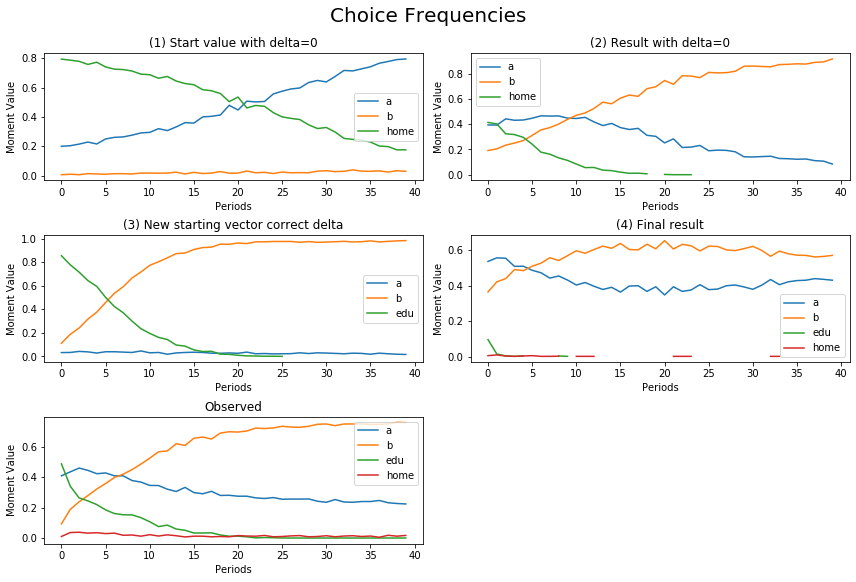

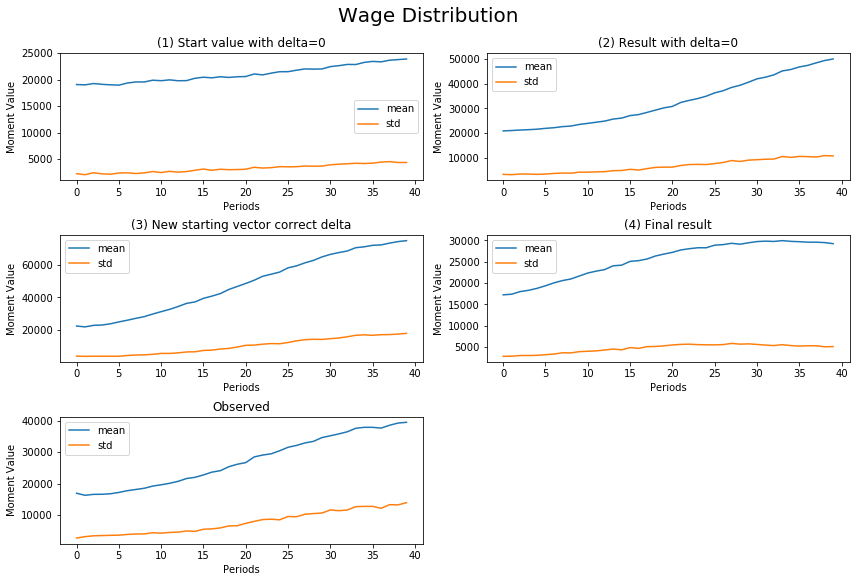

In [60]:
plot_moments(
    empirical_moments=empirical_moments, simulated_moments=simulated_moments,
)

### Difference result & observed moments

We can also easily compute the difference in moments between the estimated and observed parameters. For the choice frequencies we just look at the total difference in choice frequencies for each period.

In [33]:
diff = {}
diff["Choice Frequencies"] = empirical_moments["Choice Frequencies"] - replace_nans(
    simulated_moments["Choice Frequencies"]["(4) Final result"]
)

For the wage distribution we compute the relative deviation compared to the values of the empirical moments.

In [34]:
diff["Wage Distribution"] = (
    empirical_moments["Wage Distribution"]
    - replace_nans(simulated_moments["Wage Distribution"]["(4) Final result"])
) / empirical_moments["Wage Distribution"]

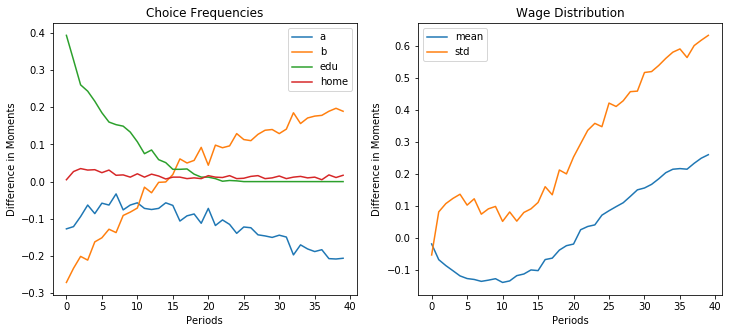

In [36]:
plt.figure(figsize=(12, 5))
plt.tight_layout()
for idx, key in enumerate(diff.keys()):
    plt.subplot(1, 2, idx + 1)
    plt.plot(diff[key])
    plt.legend(diff[key].columns, loc="best")
    plt.title(key)
    plt.xlabel("Periods")
    plt.ylabel("Difference in Moments")

### Criterion History

Lastly, we can plot the criterion history to get a picture of the optimization processes by reading in the data from the logging databases. This also shows us how many iterations the optimizer used to get to the final result. In some cases it may not use the maximum number of iterations we have specified before.

In [61]:
def plot_criterion_history(db_path, iterations):
    """Plot criterion history."""
    database = load_database(db_path)
    criterion_history = read_last_iterations(
        database, "criterion_history", iterations, "pandas"
    )
    plt.plot(criterion_history, alpha=0.5)
    plt.xlabel("Iterations")
    plt.ylabel("Criterion")
    plt.show()

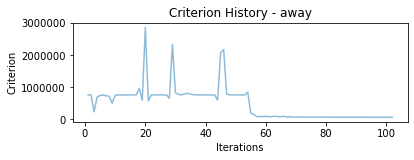

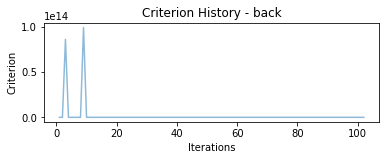

In [62]:
# Plot criterion history.
for idx, db in enumerate(["away", "back"]):
    plt.subplot(2, 1, idx + 1)
    plt.title("Criterion History - " + db)
    plot_criterion_history(
        db_path=logging_path + "/logging_" + db + ".db", iterations=10000,
    )